<a href="https://colab.research.google.com/github/PaudelSiddhanta/Rectangular_EIT/blob/main/ADAM_with_cosine_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch
import torch.nn as nn
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import copy

# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [70]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure a GPU is available for this run.")
print(f"Running on GPU: {torch.cuda.get_device_name(0)}")

Running on GPU: Tesla T4


In [71]:
# SquareEITNN class
class SquareEITNN(nn.Module):
    def __init__(self, grid):
        super(SquareEITNN, self).__init__()
        self.grid = grid
        self.n = grid.n
        self.input_size = 8 * self.n
        self.hidden_size = self.n ** 2 + 8 * self.n
        self.output_size = self.n ** 2 + 4 * self.n
        self.interior_size = self.n ** 2
        self.neumann_copy_start = self.n ** 2 + 4 * self.n
        self.device = torch.device("cuda")

        self.W1 = nn.Parameter(torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False)).to(self.device)
        self.W1_fixed = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64).to(self.device)
        self.W1_fixed_mask = torch.ones(self.hidden_size, self.input_size, dtype=torch.bool).to(self.device)
        self.W1_fixed_mask[:self.interior_size, :4*self.n] = False

        self.W1__grad = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False).to(self.device)
        self.W2__grad = torch.zeros(self.output_size, self.hidden_size, dtype=torch.float64, requires_grad=False).to(self.device)
        self._initialize_W1_blocks()
        self._initialize_W2()
    def assign_gradients(self, x_data, h, y, alpha):
        with torch.no_grad():
            batch_size = y.shape[0]
            dL_dy = torch.zeros_like(y).to(self.device)
            dL_dy[:, :self.n**2] = alpha * y[:, :self.n**2] / batch_size
            dL_dy[:, self.n**2:] = y[:, self.n**2:] / batch_size

            dW2 = dL_dy.T @ h
            grad = {}
            w2_indices = [(i, j) for i in range(self.n**2) for j in self.grid.get_node_by_index(i).neighbors if i < j < self.interior_size + 4*self.n]
            for i, j in w2_indices:
                grad[(i, j)] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]
                self.W2__grad[i, j] = grad[(i, j)] / (1 + self.Beta[i, j]**2)

            dW1 = self.W2_dynamic.T @ dL_dy.T @ x_data
            for i in range(self.n**2):
                for j in range(4*self.n):
                    self.W1__grad[i, j] = dW1[i, j]
    def _initialize_W1_blocks(self):
        with torch.no_grad():
            self.W1[:self.interior_size, :4*self.n] = torch.randn(self.interior_size, 4*self.n, dtype=torch.float64).to(self.device)
            self.W1[:self.interior_size, 4*self.n:] = 0.0
            self.W1_fixed[:self.interior_size, 4*self.n:] = 0.0
            self.W1[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1_fixed[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)

    def _initialize_W2(self):
        size_out = self.output_size
        size_hidden = self.hidden_size
        self.Beta = nn.Parameter(torch.zeros(size_out, size_hidden, dtype=torch.float64, requires_grad=False)).to(self.device)
        self.W2_fixed = torch.zeros(size_out, size_hidden, dtype=torch.float64).to(self.device)
        self.W2_mask = torch.ones(size_out, size_hidden, dtype=torch.bool).to(self.device)

        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                weights = torch.abs(torch.randn(len(neighbor_indices), dtype=torch.float64)).to(self.device)
                for k, j in enumerate(neighbor_indices):
                    self.Beta[i,j] = weights[k]
                    self.Beta[j, i] = weights[k]
                    self.W2_fixed[j, i] = weights[k]
                    self.W2_mask[i, j] = False
                self.Beta[i, i] = 0
                self.W2_fixed[i, i] = 0

            for i in range(self.interior_size + 4*self.n):
                self.Beta[i, i] = -torch.sum(torch.tensor([self.Beta[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))

            for i in range(4*self.n):
                row = self.interior_size + i
                col = self.neumann_copy_start + i
                self.Beta[row, col] = 1.0
                self.W2_fixed[row, col] = 1.0

    def symmetrize_W2_after_training(self):
        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                for k, j in enumerate(neighbor_indices):
                    self.W2_fixed[i,j] = self.transform(self.Beta[i,j])
                    self.W2_fixed[j,i] = self.transform(self.Beta[i,j])
            for i in range(self.interior_size + 4*self.n):
                self.W2_fixed[i, i] = 0
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))

    def transform(self, x):
        return torch.arctan(x) + torch.pi/2

    def forward(self, x):
        self.W1_dynamic = torch.where(self.W1_fixed_mask, self.W1_fixed, self.W1).to(self.device)
        self.W2_dynamic = torch.where(self.W2_mask, self.W2_fixed, torch.arctan(self.Beta) + torch.pi/2).to(self.device)
        hid = torch.matmul(x, self.W1_dynamic.t())
        outp = torch.matmul(hid, self.W2_dynamic.t())
        return outp, hid


In [72]:
#  generate_dtn_data
def generate_dtn_data(grid, batch_size):
    device = torch.device("cuda")
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)

    for k in range(min(batch_size, 4*grid.n)):
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)
    return data

In [73]:
#  loss_function
def loss_function(output, grid, alpha=1.0):
    device = torch.device("cuda")
    batch_size = output.size(0)
    interior = output[:, :-4*grid.n].to(device)
    boundary = output[:, -4*grid.n:].to(device)
    interior_loss = alpha * torch.sum(interior ** 2) / (2 * batch_size)
    boundary_loss = torch.sum(boundary ** 2) / (2 * batch_size)
    total_loss = interior_loss + boundary_loss
    return total_loss, interior_loss, boundary_loss

In [74]:
#  adam with step-size clipping
# we could use gradient clipping but step size clipping probably doesnt work
def adam(param, grad, alpha, m_t, v_t, beta1, beta2, eps, time_step, clip_after_steps=4000, max_step_norm=1.0):
    device = torch.device("cuda")
    with torch.no_grad():
        if grad is None:
            grad = torch.zeros_like(param).to(device)
        m_t1 = beta1 * m_t + (1 - beta1) * grad
        v_t1 = beta2 * v_t + (1 - beta2) * (grad ** 2)
        m_corr = m_t1 / (1 - beta1 ** time_step)
        v_corr = v_t1 / (1 - beta2 ** time_step)
        delta = alpha * m_corr / (torch.sqrt(v_corr) + eps)
        # # Step-size clipping after initial steps
        # if time_step > clip_after_steps:
        #     delta_norm = torch.norm(delta, p=2)
        #     if delta_norm > max_step_norm:
        #         delta = delta * max_step_norm / delta_norm
        param = param - delta
        return param, m_t1, v_t1

In [75]:
class CustomCosineAnnealingWarmRestarts:
    def __init__(self, T_0, initial_lr, T_mult=1, eta_min=1e-8, eta_max_factor=0.5):
        self.T_0 = T_0  # Length of first cycle
        self.T_mult = T_mult  # Multiplier for cycle length
        self.eta_min = eta_min  # Minimum learning rate
        self.eta_max_factor = eta_max_factor  # Decay factor for max learning rate
        self.t = 0  # Current step
        self.cycle = 0  # Current cycle number
        self.T_cur = T_0  # Current cycle length
        self.base_lr = initial_lr  # Initial maximum learning rate

    def step(self):
        if self.t >= self.T_cur:  # End of cycle
            self.cycle += 1
            self.base_lr *= self.eta_max_factor  # Decay max learning rate
            self.T_cur = self.T_0 * (self.T_mult ** self.cycle)  # Update cycle length
            self.t = 0  # Reset step counter
        # Cosine annealing formula
        lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + np.cos(np.pi * self.t / self.T_cur))
        self.t += 1
        return lr

In [92]:
def train_model_adam(num_epoch, dataloader, model, alpha, learning_rate, grid, min_lr = 1e-10,eta_max = 0.01,
                     beta1=0.9, beta2=0.99, eps=1e-8, patience=4000, init_delta_thresh=1e-4, cycle_length=4000):
    device = torch.device("cuda")
    model.to(device)
    num_epochs = num_epoch
    loss_record = []
    interior_loss_record = []
    boundary_loss_record = []

    # Initialize Adam states
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})

    # Custom CosineAnnealingWarmRestarts scheduler
    scheduler = CustomCosineAnnealingWarmRestarts(T_0=cycle_length, initial_lr=learning_rate, T_mult=1, eta_min=1e-8, eta_max_factor=eta_max)
    t = 1
    best_loss = float('inf')
    epochs_since_improvement = 0
    # min_lr = 1e-10
    alpha_min = 0.2

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        interior_loss_epoch = 0.0
        boundary_loss_epoch = 0.0
        num_batches = 0

        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            model.zero_grad()
            output, hid = model(batch_x)
            total_loss, interior_loss, boundary_loss = loss_function(output, grid, alpha)
            model.assign_gradients(batch_x, hid, output, alpha)

            # Update parameters
            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam(param, grad, learning_rate, m, v, beta1, beta2, eps, t)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v

                #this is not necessary
                # # Log step-size norm for monitoring
                # delta = learning_rate * (new_m / (1 - beta1 ** t)) / (torch.sqrt(new_v / (1 - beta2 ** t)) + eps)
                # delta_norm = torch.norm(delta, p=2).item()
                # if t % 100 == 0:
                #     print(f"Step {t}: Delta norm ({state['name']}): {delta_norm:.6f}")
            t += 1
            model.symmetrize_W2_after_training()

            total_loss_epoch += total_loss.item()
            interior_loss_epoch += interior_loss.item()
            boundary_loss_epoch += boundary_loss.item()
            num_batches += 1

        # Average losses for the epoch
        total_loss_epoch /= num_batches
        interior_loss_epoch /= num_batches
        boundary_loss_epoch /= num_batches
        loss_record.append(total_loss_epoch)
        interior_loss_record.append(interior_loss_epoch)
        boundary_loss_record.append(boundary_loss_epoch)

        # # Adaptive alpha based on loss ratio
        # if interior_loss_epoch > 0 and boundary_loss_epoch > 0:
        #     alpha = max(alpha_min, interior_loss_epoch / (boundary_loss_epoch + 1e-10))

        # Update learning rate
        learning_rate = max(scheduler.step(), min_lr)

        # Log scheduler state
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss_epoch:.6e}, Interior: {interior_loss_epoch:.6e}, Boundary: {boundary_loss_epoch:.6e}, Alpha: {alpha:.4f}, LR: {learning_rate:.6e}, Base LR: {scheduler.base_lr:.6e}, Cycle: {scheduler.cycle}, T_cur: {scheduler.T_cur}")

        # Early stopping
        if total_loss_epoch < best_loss - init_delta_thresh:
            best_loss = total_loss_epoch
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if total_loss_epoch < 1e-12:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (loss < 1e-8)")
            break

        if epochs_since_improvement >= patience:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (no improvement)")
            break

    # Final processing
    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    return loss_record, interior_loss_record, boundary_loss_record, estimated_conductivities

In [77]:
# Training for n=2 (unchanged)
n = 2
batch_size = min(4*n, 32)  # Cap batch size for larger n
grid1 = GridStructure(n)
data1 = generate_dtn_data(grid1, batch_size)
dataloader1 = DataLoader(data1, batch_size=batch_size, shuffle=True)
model1 = SquareEITNN(grid1)
alpha1 = 0.7
num_epoch1 = 30000
learning_rate1 = 0.002
cycle_length1 = 5000



Epoch [1000/30000], Total Loss: 3.606406e-01, Interior: 2.072918e-01, Boundary: 1.533488e-01, Alpha: 0.7000, LR: 1.809387e-03, Base LR: 2.000000e-03, Cycle: 0, T_cur: 5000
Epoch [2000/30000], Total Loss: 1.269717e-02, Interior: 1.304168e-03, Boundary: 1.139300e-02, Alpha: 0.7000, LR: 1.309618e-03, Base LR: 2.000000e-03, Cycle: 0, T_cur: 5000
Epoch [3000/30000], Total Loss: 2.624095e-03, Interior: 2.382860e-04, Boundary: 2.385809e-03, Alpha: 0.7000, LR: 6.915872e-04, Base LR: 2.000000e-03, Cycle: 0, T_cur: 5000
Epoch [4000/30000], Total Loss: 1.341995e-03, Interior: 1.204531e-04, Boundary: 1.221542e-03, Alpha: 0.7000, LR: 1.913615e-04, Base LR: 2.000000e-03, Cycle: 0, T_cur: 5000
Epoch [5000/30000], Total Loss: 1.206370e-03, Interior: 1.081444e-04, Boundary: 1.098226e-03, Alpha: 0.7000, LR: 1.019739e-08, Base LR: 2.000000e-03, Cycle: 0, T_cur: 5000
Epoch [6000/30000], Total Loss: 3.080399e-04, Interior: 2.800154e-05, Boundary: 2.800384e-04, Alpha: 0.7000, LR: 9.046940e-04, Base LR: 1.00

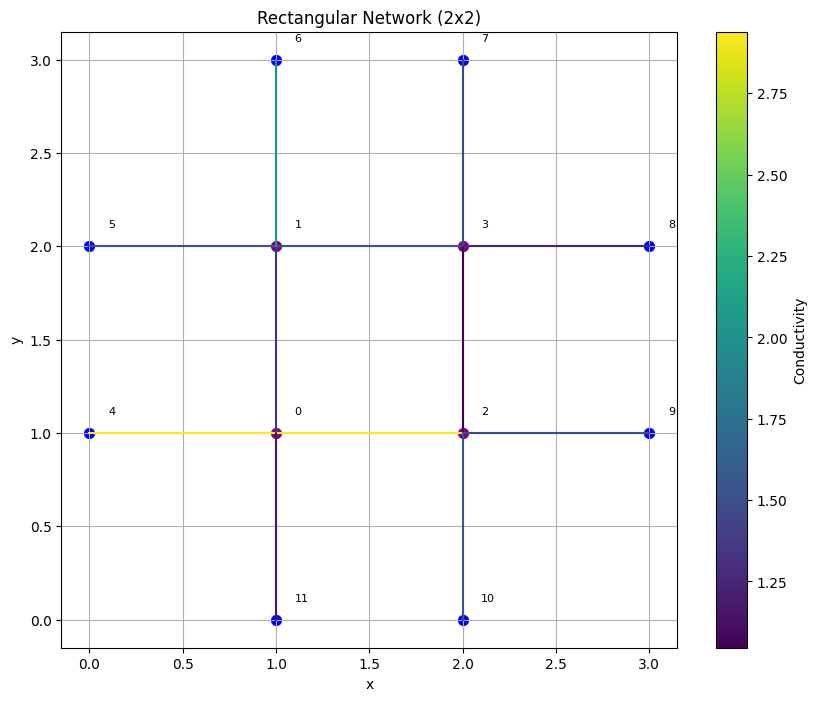

Recovered Conductivity


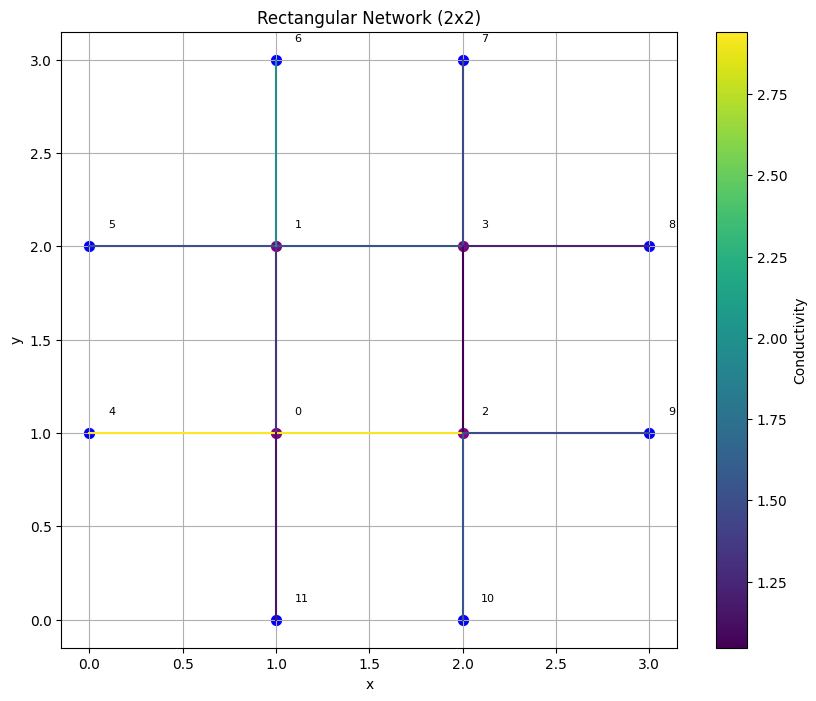

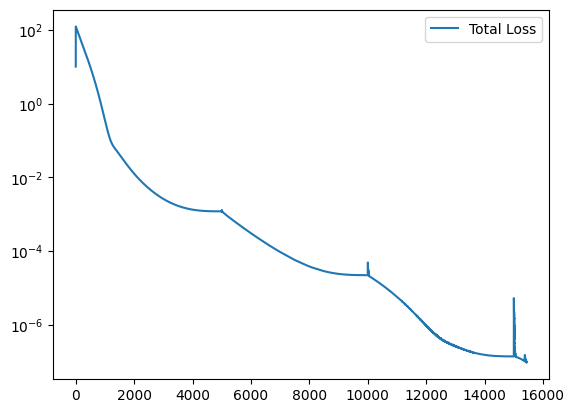

In [78]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_model_adam(
    num_epoch1, dataloader1, model1, alpha1, learning_rate1, grid1, min_lr = 1e-10,eta_max = 0.01
    beta1=0.9, beta2=0.99, eps=1e-8, patience=cycle_length1, init_delta_thresh=1e-4, cycle_length=cycle_length1
)
plt.plot(loss_record, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [86]:
#Training for n=6
n = 6
batch_size = min(4*n, 32)  # Cap batch size
grid3 = GridStructure(n)
data3 = generate_dtn_data(grid3, batch_size)
dataloader3 = DataLoader(data3, batch_size=batch_size, shuffle=True)
model3 = SquareEITNN(grid3)
alpha3 = 0.7
num_epoch3 = 30000
learning_rate3 = 0.02
cycle_length3 = 5000



Epoch [1000/30000], Total Loss: 4.994060e-02, Interior: 7.394124e-03, Boundary: 4.254647e-02, Alpha: 0.7000, LR: 1.809386e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [2000/30000], Total Loss: 5.176007e-04, Interior: 2.807316e-04, Boundary: 2.368691e-04, Alpha: 0.7000, LR: 1.309615e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [3000/30000], Total Loss: 1.121920e-04, Interior: 9.854295e-05, Boundary: 1.364904e-05, Alpha: 0.7000, LR: 6.915813e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [4000/30000], Total Loss: 8.908725e-06, Interior: 5.134568e-06, Boundary: 3.774157e-06, Alpha: 0.7000, LR: 1.913534e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [5000/30000], Total Loss: 2.706828e-06, Interior: 6.079614e-07, Boundary: 2.098866e-06, Alpha: 0.7000, LR: 1.197392e-08, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [6000/30000], Total Loss: 2.447621e-04, Interior: 2.336639e-04, Boundary: 1.109818e-05, Alpha: 0.7000, LR: 9.046932e-03, Base LR: 1.00

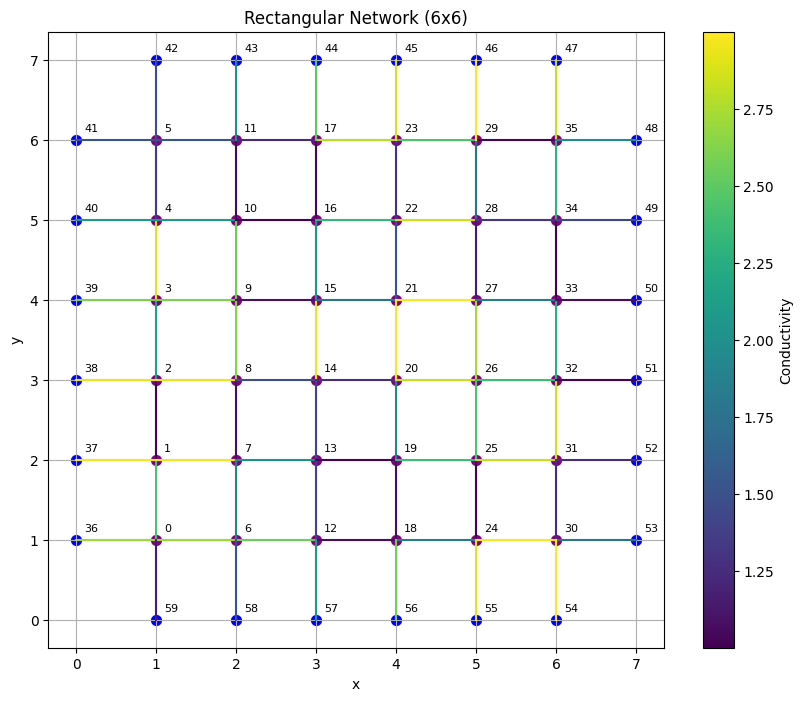

Recovered Conductivity


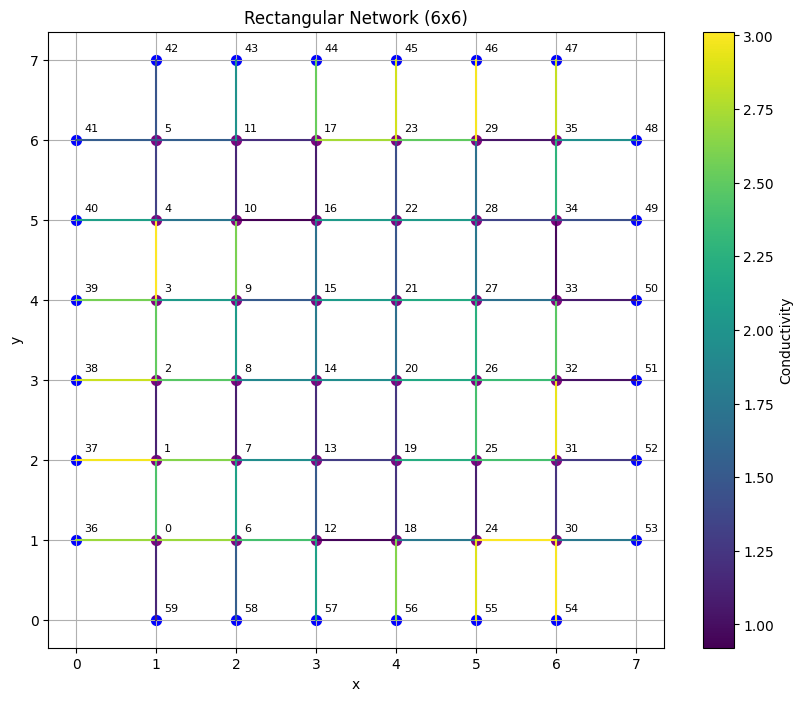

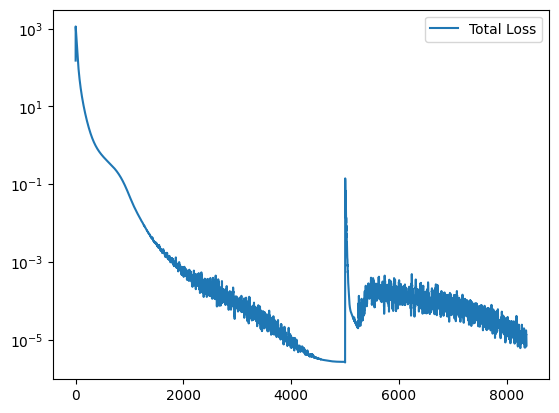

In [87]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_model_adam(
    num_epoch3, dataloader3, model3, alpha3, learning_rate3, grid3,
    beta1=0.9, beta2=0.99, eps=1e-8, patience=cycle_length3, init_delta_thresh=1e-4, cycle_length=cycle_length3
)

plt.plot(loss_record, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

observe that the loss spikes at around 5000 epochs when the learning rate gets reset. So, this time we decrease the learning rate factor and increase the patience
also now, we added two more arguments to the function. min_lr and eta_max, we reduce the min_lr to 1e-10 and set eta_max to 0.01 to see if we improve the loss

In [93]:
#  Training for n=6
n = 6
batch_size = min(4*n, 32)  # Cap batch size
grid3 = GridStructure(n)
data3 = generate_dtn_data(grid3, batch_size)
dataloader3 = DataLoader(data3, batch_size=batch_size, shuffle=True)
model3 = SquareEITNN(grid3)
alpha3 = 0.7
num_epoch3 = 30000
learning_rate3 = 0.02
cycle_length3 = 5000


Epoch [1000/30000], Total Loss: 4.785782e-02, Interior: 8.839037e-03, Boundary: 3.901878e-02, Alpha: 0.7000, LR: 1.809386e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [2000/30000], Total Loss: 4.066870e-04, Interior: 2.264415e-04, Boundary: 1.802455e-04, Alpha: 0.7000, LR: 1.309615e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [3000/30000], Total Loss: 8.176568e-05, Interior: 6.981557e-05, Boundary: 1.195011e-05, Alpha: 0.7000, LR: 6.915813e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [4000/30000], Total Loss: 8.759202e-06, Interior: 5.635159e-06, Boundary: 3.124043e-06, Alpha: 0.7000, LR: 1.913534e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [5000/30000], Total Loss: 2.187427e-06, Interior: 5.118467e-07, Boundary: 1.675580e-06, Alpha: 0.7000, LR: 1.197392e-08, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000
Epoch [6000/30000], Total Loss: 1.574979e-06, Interior: 4.490335e-07, Boundary: 1.125945e-06, Alpha: 0.7000, LR: 1.809396e-04, Base LR: 2.00

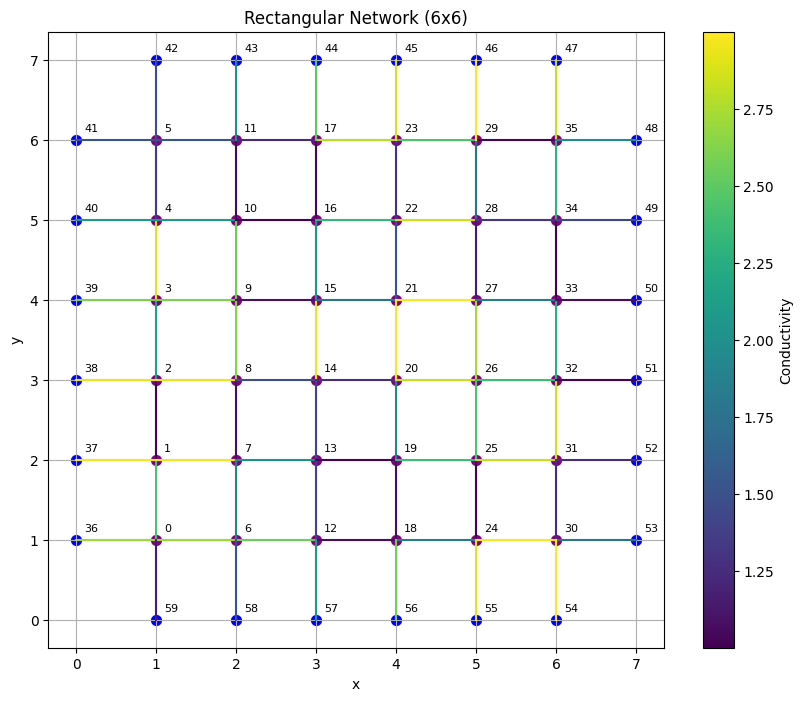

Recovered Conductivity


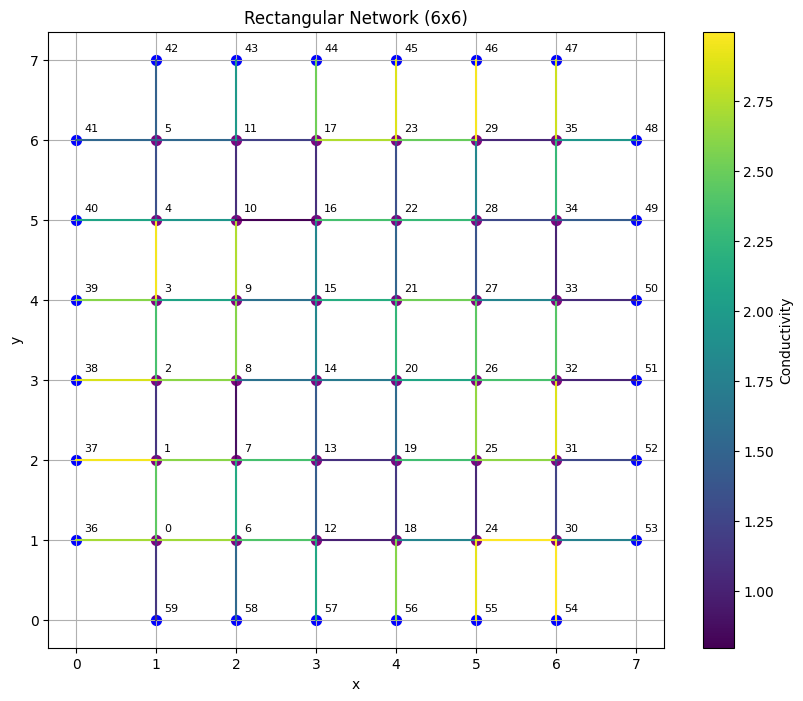

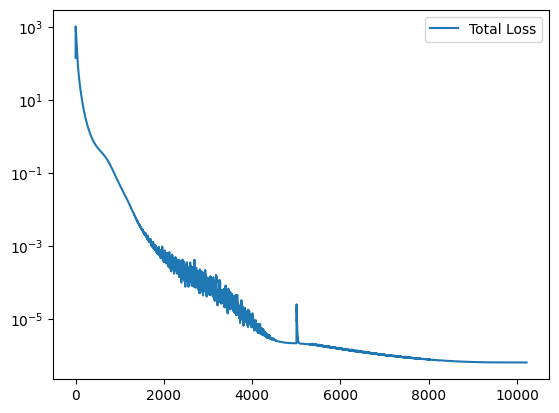

In [94]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_model_adam(
    num_epoch3, dataloader3, model3, alpha3, learning_rate3, grid3,  min_lr = 1e-10,eta_max = 0.01,
    beta1=0.9, beta2=0.99, eps=1e-8, patience=1.5*cycle_length3, init_delta_thresh=1e-4, cycle_length=cycle_length3
)

plt.plot(loss_record, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

Couple of ideas: Now we modify the train method to keep track of the best learning rates, and if we see no improvement, we do two things: decrease init_delta_thresh depending on the magnitude of the best loss (if the best loss is of the order 10^-7, we can't expect it to decrease by 10^-4 more, it has to change with time). The next idea is to then set the maximum value of eta in custom_cosine_lr function to 1000 times the best learning rate and continue the training until all epochs are trained. So, the only way we stop is either we complete all 30k epochs or our loss becomes of the order 10^-12. or we could first start with gradient clipping and then move to the cosinelr thing.


In [96]:
#adam_with_grad_clip with gradient clipping
def adam_with_grad_clip(param, grad, alpha, m_t, v_t, beta1, beta2, eps, time_step, max_grad_norm=1.0):
    device = torch.device("cuda")
    with torch.no_grad():
        if grad is None:
            grad = torch.zeros_like(param).to(device)
        # Gradient clipping
        grad_norm = torch.norm(grad, p=2)
        if grad_norm > max_grad_norm:
            grad = grad * max_grad_norm / grad_norm
        m_t1 = beta1 * m_t + (1 - beta1) * grad
        v_t1 = beta2 * v_t + (1 - beta2) * (grad ** 2)
        m_corr = m_t1 / (1 - beta1 ** time_step)
        v_corr = v_t1 / (1 - beta2 ** time_step)
        delta = alpha * m_corr / (torch.sqrt(v_corr) + eps)
        param = param - delta
        return param, m_t1, v_t1

In [101]:
def train_adaptive(num_epoch, dataloader, model, alpha, learning_rate, grid, min_lr=1e-10, eta_max=0.05,
                   beta1=0.9, beta2=0.99, eps=1e-8, patience=4000, init_delta_thresh=1e-4, cycle_length=4000):
    device = torch.device("cuda")
    model.to(device)
    num_epochs = num_epoch
    loss_record = []
    interior_loss_record = []
    boundary_loss_record = []

    # Initialize Adam states
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})

    # Custom CosineAnnealingWarmRestarts scheduler
    scheduler = CustomCosineAnnealingWarmRestarts(T_0=cycle_length, initial_lr=learning_rate, T_mult=1, eta_min=min_lr, eta_max_factor=eta_max)
    t = 1
    best_loss = float('inf')
    best_lr = learning_rate
    epochs_since_improvement = 0
    alpha_min = 0.2

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        interior_loss_epoch = 0.0
        boundary_loss_epoch = 0.0
        num_batches = 0

        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            model.zero_grad()
            output, hid = model(batch_x)
            total_loss, interior_loss, boundary_loss = loss_function(output, grid, alpha)
            model.assign_gradients(batch_x, hid, output, alpha)

            # Update parameters
            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam_with_grad_clip(param, grad, learning_rate, m, v, beta1, beta2, eps, t, max_grad_norm=1.0)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1
            model.symmetrize_W2_after_training()

            total_loss_epoch += total_loss.item()
            interior_loss_epoch += interior_loss.item()
            boundary_loss_epoch += boundary_loss.item()
            num_batches += 1

        # Average losses for the epoch
        total_loss_epoch /= num_batches
        interior_loss_epoch /= num_batches
        boundary_loss_epoch /= num_batches
        loss_record.append(total_loss_epoch)
        interior_loss_record.append(interior_loss_epoch)
        boundary_loss_record.append(boundary_loss_epoch)

        # Update learning rate
        learning_rate = max(scheduler.step(), min_lr)


                # Update init_delta_thresh based on best_loss
        if total_loss_epoch < best_loss - init_delta_thresh:
            best_loss = total_loss_epoch
            best_lr = learning_rate
            # Compute order of magnitude of best_loss
            if best_loss > 0:
                order = np.floor(np.log10(best_loss))
                init_delta_thresh = 1e-3 * 10 ** order  # 10^-3 times the order of best_loss
            # No else: if best_loss = 0, keep previous init_delta_thresh or stop
            epochs_since_improvement = 0
        elif best_loss == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (best_loss = 0)")
            break
        else:
            epochs_since_improvement += 1

        # Log scheduler state
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss_epoch:.6e}, Interior: {interior_loss_epoch:.6e}, Boundary: {boundary_loss_epoch:.6e}, Alpha: {alpha:.4f}, LR: {learning_rate:.6e}, Best LR: {best_lr:.6e}, Base LR: {scheduler.base_lr:.6e}, Cycle: {scheduler.cycle}, T_cur: {scheduler.T_cur}, Delta Thresh: {init_delta_thresh:.6e}")

        # Early stopping
        if total_loss_epoch < 1e-12:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (loss < 1e-12)")
            break

        if epochs_since_improvement >= patience:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (no improvement)")
            break

    # Final processing
    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    return loss_record, interior_loss_record, boundary_loss_record, estimated_conductivities

In [102]:
n1 = 6
batch_size = min(4*n1, 32)  # Cap batch size
grid3_1 = GridStructure(n1)
data3_1 = generate_dtn_data(grid3_1, batch_size)
dataloader3_1 = DataLoader(data3_1, batch_size=batch_size, shuffle=True)
model3_1 = SquareEITNN(grid3)
alpha3_1 = 0.7
num_epoch3_1 = 30000
learning_rate3_1= 0.02
cycle_length3_1 = 5000



Epoch [1000/30000], Total Loss: 1.902899e-03, Interior: 8.397361e-04, Boundary: 1.063163e-03, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.809755e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-06
Epoch [2000/30000], Total Loss: 3.114554e-04, Interior: 2.798416e-04, Boundary: 3.161380e-05, Alpha: 0.7000, LR: 1.309615e-02, Best LR: 1.390795e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07
Epoch [3000/30000], Total Loss: 9.677347e-05, Interior: 8.794033e-05, Boundary: 8.833146e-06, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 7.077618e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-08
Epoch [4000/30000], Total Loss: 4.724037e-06, Interior: 2.278385e-06, Boundary: 2.445652e-06, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 1.913525e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-09
Epoch [5000/30000], Total Loss: 1.818584e-06, Interior: 4.259890e-07, Boundary: 1.392595e-06, Alpha: 0.7000,

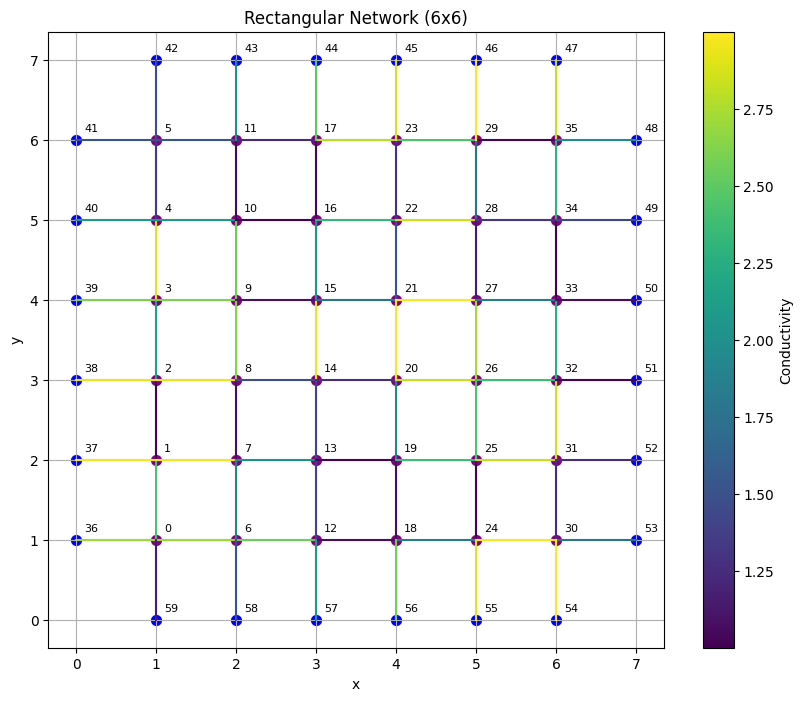

Recovered Conductivity


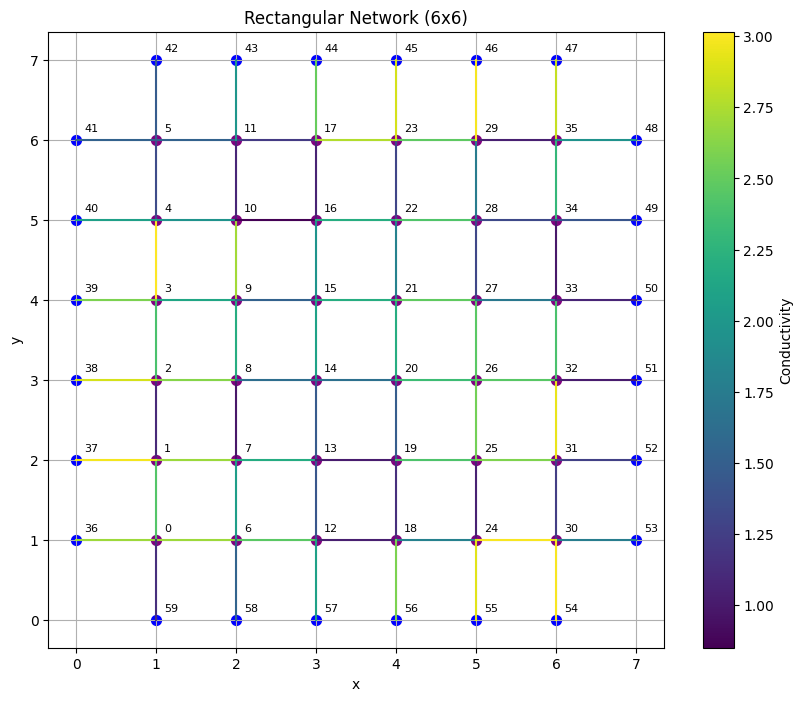

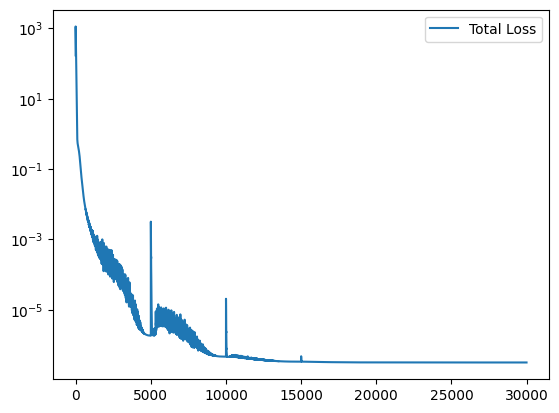

In [103]:
loss_record3_1, interior_loss, boundary_loss, estimated_conductivities = train_adaptive(
    num_epoch3_1, dataloader3_1, model3_1, alpha3_1, learning_rate3_1, grid3_1, min_lr=1e-10, eta_max=0.08,
    beta1=0.9, beta2=0.99, eps=1e-8, patience=1.5*cycle_length3_1, init_delta_thresh=1e-4, cycle_length=cycle_length3_1
)
plt.plot(loss_record3_1, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

the next idea is to increase the value of alpha after a certain point, when let's say both the interior and the boundary loss are in the order of 10^-7, we increase it to 0.8 and 0.9 and then 1. We can do it after 10^-7 and then 10^-8 and then 10^-9. We could also do the following, when the base learning rate decreases to 10^-7, we can increase it back to around 10^-5 or even 10^-4 and then kind of restart again to see if we get a better loss, because it seems that after that range, the interior and the boundary loss seem to stagnate.

In [105]:
class CustomCosineAnnealingWarmRestarts_withReset:
    def __init__(self, T_0, initial_lr, T_mult=1, eta_min=1e-8, eta_max_factor=0.08):
        self.T_0 = T_0  # Length of first cycle
        self.T_mult = T_mult  # Multiplier for cycle length
        self.eta_min = eta_min  # Minimum learning rate
        self.eta_max_factor = eta_max_factor  # Decay factor for max learning rate
        self.t = 0  # Current step
        self.cycle = 0  # Current cycle number
        self.T_cur = T_0  # Current cycle length
        self.base_lr = initial_lr  # Initial maximum learning rate

    def step(self):
        if self.t >= self.T_cur:  # End of cycle
            self.cycle += 1
            self.base_lr *= self.eta_max_factor  # Decay max learning rate
            self.T_cur = self.T_0 * (self.T_mult ** self.cycle)  # Update cycle length
            self.t = 0  # Reset step counter
        # Cosine annealing formula
        lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + np.cos(np.pi * self.t / self.T_cur))
        self.t += 1
        return lr

    def reset(self, new_base_lr):
        self.base_lr = new_base_lr
        self.cycle = 0
        self.T_cur = self.T_0
        self.t = 0

In [106]:
def train_adaptive2(num_epoch, dataloader, model, alpha, learning_rate, grid, min_lr=1e-10, eta_max=0.08,
                   beta1=0.9, beta2=0.99, eps=1e-8, patience=7500, init_delta_thresh=1e-4, cycle_length=5000):
    device = torch.device("cuda")
    model.to(device)
    num_epochs = num_epoch
    loss_record = []
    interior_loss_record = []
    boundary_loss_record = []

    # Initialize Adam states
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})

    # Custom CosineAnnealingWarmRestarts scheduler
    scheduler = CustomCosineAnnealingWarmRestarts_withReset(T_0=cycle_length, initial_lr=learning_rate, T_mult=1, eta_min=min_lr, eta_max_factor=eta_max)
    t = 1
    best_loss = float('inf')
    best_lr = learning_rate
    epochs_since_improvement = 0

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        interior_loss_epoch = 0.0
        boundary_loss_epoch = 0.0
        num_batches = 0

        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            model.zero_grad()
            output, hid = model(batch_x)
            total_loss, interior_loss, boundary_loss = loss_function(output, grid, alpha)
            model.assign_gradients(batch_x, hid, output, alpha)

            # Update parameters
            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam_with_grad_clip(param, grad, learning_rate, m, v, beta1, beta2, eps, t, max_grad_norm=1.0)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1
            model.symmetrize_W2_after_training()

            total_loss_epoch += total_loss.item()
            interior_loss_epoch += interior_loss.item()
            boundary_loss_epoch += boundary_loss.item()
            num_batches += 1

        # Average losses for the epoch
        total_loss_epoch /= num_batches
        interior_loss_epoch /= num_batches
        boundary_loss_epoch /= num_batches
        loss_record.append(total_loss_epoch)
        interior_loss_record.append(interior_loss_epoch)
        boundary_loss_record.append(boundary_loss_epoch)

        # Update alpha based on loss thresholds
        min_loss = min(interior_loss_epoch, boundary_loss_epoch)
        if min_loss < 1e-9 and alpha < 1.0:
            alpha = 1.0
        elif min_loss < 1e-8 and alpha < 0.9:
            alpha = 0.9
        elif min_loss < 1e-7 and alpha < 0.8:
            alpha = 0.8

        # Update learning rate
        learning_rate = max(scheduler.step(), min_lr)

        # Reset learning rate if base_lr falls below 1e-7
        if scheduler.base_lr < 1e-7:
            scheduler.reset(new_base_lr=1e-4)
            learning_rate = scheduler.step()
            print(f"Epoch [{epoch+1}/{num_epochs}], Resetting Base LR to 1e-4")

        # Update init_delta_thresh based on best_loss
        if total_loss_epoch < best_loss - init_delta_thresh:
            best_loss = total_loss_epoch
            best_lr = learning_rate
            # Compute order of magnitude of best_loss
            if best_loss > 0:
                order = np.floor(np.log10(best_loss))
                init_delta_thresh = 1e-4 * 10 ** order  # 10^-4 times the order of best_loss
            # No else: if best_loss = 0, keep previous init_delta_thresh or stop
            epochs_since_improvement = 0
        elif best_loss == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (best_loss = 0)")
            break
        else:
            epochs_since_improvement += 1

        # Log scheduler state
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss_epoch:.6e}, Interior: {interior_loss_epoch:.6e}, Boundary: {boundary_loss_epoch:.6e}, Alpha: {alpha:.4f}, LR: {learning_rate:.6e}, Best LR: {best_lr:.6e}, Base LR: {scheduler.base_lr:.6e}, Cycle: {scheduler.cycle}, T_cur: {scheduler.T_cur}, Delta Thresh: {init_delta_thresh:.6e}")

        # Early stopping
        if total_loss_epoch < 1e-12:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (loss < 1e-12)")
            break

        if epochs_since_improvement >= patience:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (no improvement)")
            break

    # Final processing
    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    return loss_record, interior_loss_record, boundary_loss_record, estimated_conductivities

In [107]:
n1 = 6
batch_size = min(4*n1, 32)  # Cap batch size
grid3_1 = GridStructure(n1)
data3_1 = generate_dtn_data(grid3_1, batch_size)
dataloader3_1 = DataLoader(data3_1, batch_size=batch_size, shuffle=True)
model3_1 = SquareEITNN(grid3)
alpha3_1 = 0.7
num_epoch3_1 = 30000
learning_rate3_1= 0.02
cycle_length3_1 = 5000

In [ ]:
loss_record3_1, interior_loss, boundary_loss, estimated_conductivities = train_adaptive2(
    num_epoch3_1, dataloader3_1, model3_1, alpha3_1, learning_rate3_1, grid3_1, min_lr=1e-10, eta_max=0.08,
    beta1=0.9, beta2=0.99, eps=1e-8, patience=1.5*cycle_length3_1, init_delta_thresh=1e-4, cycle_length=cycle_length3_1
)
plt.plot(loss_record3_1, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

Epoch [1000/30000], Total Loss: 1.713905e-03, Interior: 6.729570e-04, Boundary: 1.040948e-03, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.810124e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07
Epoch [2000/30000], Total Loss: 3.943917e-04, Interior: 3.587827e-04, Boundary: 3.560895e-05, Alpha: 0.7000, LR: 1.309615e-02, Best LR: 1.527312e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-08
Epoch [3000/30000], Total Loss: 5.099658e-05, Interior: 4.258147e-05, Boundary: 8.415113e-06, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 7.204056e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-09
Epoch [4000/30000], Total Loss: 6.229864e-06, Interior: 3.343198e-06, Boundary: 2.886666e-06, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 1.932047e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-10
Epoch [5000/30000], Total Loss: 2.205741e-06, Interior: 5.318883e-07, Boundary: 1.673852e-06, Alpha: 0.7000,